# FordA dataset

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_and_extract_archive
from scipy.io.arff import loadarff 
import time
from tqdm.notebook import tqdm

# local matplotlib seetings
colormap = ListedColormap(["#ff595e","#ffca3a","#8ac926","#52a675","#1982c4","#6a4c93"], name="Custom")

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colormap.colors)
plt.rcParams['axes.axisbelow'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


In [2]:
dir_name = "FordA"
zip_filename = "FordA.zip"
uri = r"http://www.timeseriesclassification.com/Downloads/FordA.zip"

if "FordA" not in os.listdir():
    os.mkdir("FordA")

download_location = os.path.join(os.getcwd(), dir_name)
download_and_extract_archive(url=uri, download_root=download_location, filename=zip_filename)

Using downloaded and verified file: C:\Users\A0663043\OneDrive - ArcelorMittal\Documents\Doktorat AGH\ML_CUDA\FordA\FordA.zip
Extracting C:\Users\A0663043\OneDrive - ArcelorMittal\Documents\Doktorat AGH\ML_CUDA\FordA\FordA.zip to C:\Users\A0663043\OneDrive - ArcelorMittal\Documents\Doktorat AGH\ML_CUDA\FordA


In [3]:
raw_data = loadarff(r"FordA/FordA_TRAIN.arff")
df = pd.DataFrame(raw_data[0])
df["target"] = df["target"].astype(int).replace(-1, 0)
# inverse the labels
df["target"] = df["target"].astype('category')



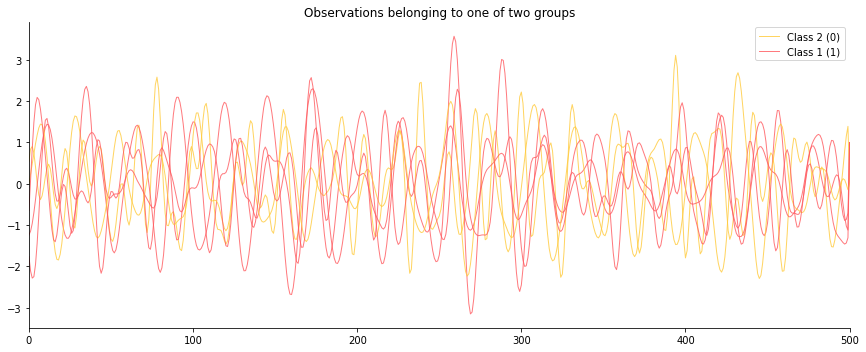

In [4]:
np.random.seed(42)

label_class_1 = "Class 1 (1)"
label_class_2 = "Class 2 (0)"

plt.figure(figsize=(12, 5))
plt.title("Observations belonging to one of two groups")
for i in np.random.randint(0, len(df), size=(5) ):
    if df.loc[i, "target"] == 1:
        color = colormap(0)
        label = label_class_1
    else:
        color = colormap(1)
        label = label_class_2
    
    plt.plot(df.values[i], color=color, alpha=0.8, label=label, linewidth=1)
    
    if label == label_class_1:
        label_class_1 = None
    if label == label_class_2:
        label_class_2 = None
    
plt.legend()
plt.tight_layout()
plt.xlim(0, 500)
plt.show()

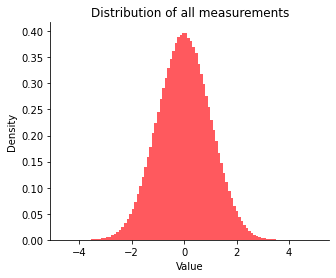

In [5]:
measurements = df.values[:, :-1].reshape((-1))

plt.figure(figsize=(5, 4))
plt.title("Distribution of all measurements")
plt.hist(measurements, bins=100, density=True)
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In [6]:
X = torch.FloatTensor(df.drop("target", axis=1).values.reshape((len(df), 1, 1, -1)))
y = torch.FloatTensor(df["target"].values)#.reshape((-1, 1)))

train_size = 0.75
i = int(train_size * len(df))

X_train, y_train = X[:i], y[:i]
X_test, y_test = X[i:], y[i:]

In [7]:
class FordADataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        item = self.features[idx]
        label = self.target[idx]
        
        return item, label
    
train = FordADataset(X_train, y_train)
test = FordADataset(X_test, y_test)

train_loader = DataLoader(train, batch_size=32, shuffle=False)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

In [8]:
class CNN_GradCAM(nn.Module):
    """This class implements a CNN with GradCAM"""
    def __init__(self, input_shape):
        super().__init__()
        
        self.input_shape = input_shape
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 5))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 5))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(1, 5))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(1, 2))
        
        flat_size = self._infer_flat_size()
        
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(flat_size, 50)
        self.fc2 = nn.Linear(50, 1)
        self.softmax = nn.Softmax(dim=-1)
        self.sigmoid = nn.Sigmoid()
        
        # placeholder for the gradients
        self.gradients = None
    
    def conv(self, x):
        # 1st convolution
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 2nd convolution
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 3rd convolution without pooling
        x = self.conv3(x)
        x = self.relu(x)
        
        return x
    
    def fully_connected(self, x):
        
        # flatten & fully connected layers
        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.softmax(x)
        x = self.sigmoid(x)
        
        return x
    
    def forward(self, x, cam=False):
        # convolution
        x = self.conv(x)
        
        if cam:
            h = x.register_hook(self.activations_hook)
            
        x = self.pool(x)
        x = self.fully_connected(x)      

        return x
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.conv(x)
    
    def gradcam(self, x):
        """ Computes Grad-CAM """
        pred = self.forward(x, register_hook=True)
        pred.backward()
        gradients = self.get_activations_gradient()
        # print("Gradients shape: {}".format(gradients.shape))

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # print("Pooled Gradients shape: {}".format(pooled_gradients.shape))

        activations = self.get_activations(x).detach()
        # print("Activations shape: {}".format(activations.shape))

        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        mean_activations = torch.mean(activations, dim=1).squeeze()
        mean_activations = torch.maximum(mean_activations, torch.tensor(0))
        mean_activations = reshape_transform(mean_activations, (x.shape[-2], x.shape[-1]))
        return mean_activations
      
    def _infer_flat_size(self):
        x = self.conv(torch.ones(*self.input_shape))
        x = self.pool(x)
        flat_size = x.view(-1).shape[0]
        
        return flat_size


In [9]:
def fit(model, data_loader):
    running_loss = .0
    model.train()
    
    for idx, (inputs, labels) in tqdm(enumerate(data_loader), total=data_loader.__len__(), disable=True):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #print(inputs.float()[:, 0].shape )
        
        preds = model(inputs.float())[:, 0]        
        loss = loss_function(preds ,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(data_loader)
    train_loss = train_loss.detach().numpy()
    return train_loss

def validate(model, data_loader):
    running_loss = .0
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())[:, 0]
            loss = loss_function(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(data_loader)
        valid_loss = valid_loss.detach().numpy()
        
        return valid_loss



In [10]:
# run training 

device = torch.device("cpu")
model = CNN_GradCAM(X_train.shape[1:]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
loss_function = nn.BCELoss()
    
train_losses = []
valid_losses = []

# training settings
epochs = 50
min_loss_increase = 1e-5
epochs_wait_max = 5
epochs_wait = 0
current_loss = 1e6

t = tqdm(range(epochs), desc='Training for %i epochs' % epochs, leave=True)
  
    
for epoch in t:
    start = time.time()
    train_loss = fit(model, train_loader)
    train_losses.append(train_loss)
    valid_loss = validate(model, test_loader)
    valid_losses.append(valid_loss)
    time_elapsed = time.time() - start
    
    
    # the code below ensures that we do not overfit the model
    if (current_loss - valid_loss) < min_loss_increase:
        epochs_wait +=1
    else:
        current_loss = valid_loss
        epochs_wait = 0
        
    if epochs_wait == epochs_wait_max:
        print("Not enough progress in last %i epochs, end of training." % epochs_wait_max)
        break
        
    # update progress bar
    t.set_description("Current Loss: train = %.3g, validation = %.3g)" % (train_loss, valid_loss))
    t.refresh() 

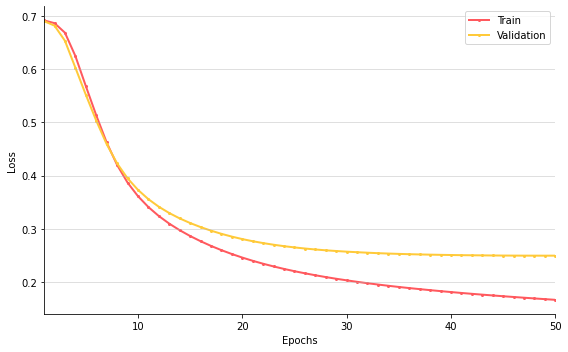

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
epochs_passed = len(train_losses)
ax.plot(range(1, epochs_passed + 1), train_losses, label="Train", linewidth=2, marker='o', markersize=2)
ax.plot(range(1, epochs_passed + 1), valid_losses, label="Validation", linewidth=2, marker='o', markersize=2)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_xlim(1, len(train_losses))
ax.legend()
ax.grid(axis='y', alpha=0.5)
fig.tight_layout()

In [12]:
from sklearn.metrics import accuracy_score

y_pred_train = model(X_train).view(-1).detach().numpy().round().astype(int)

y_pred_test = model(X_test).view(-1).detach().numpy().round().astype(int)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print("Test accuracy: %.3g" % (100 * acc_train) + "%")
print("Test accuracy: %.3g" % (100 * acc_test) + "%")

Test accuracy: 94%
Test accuracy: 91.1%


C:\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


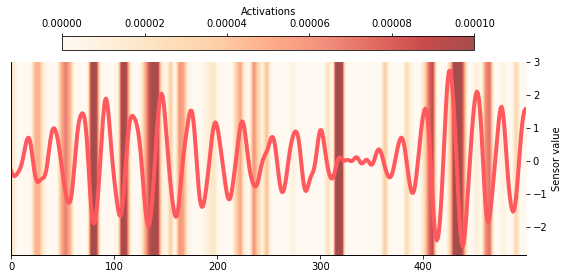

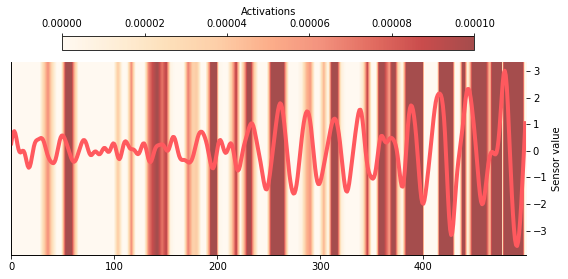

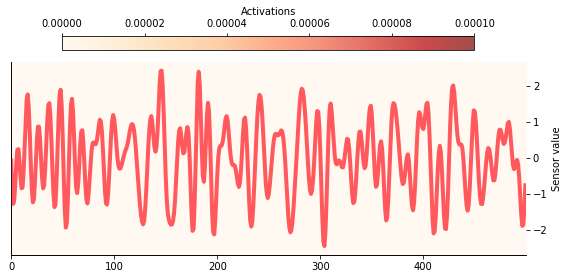

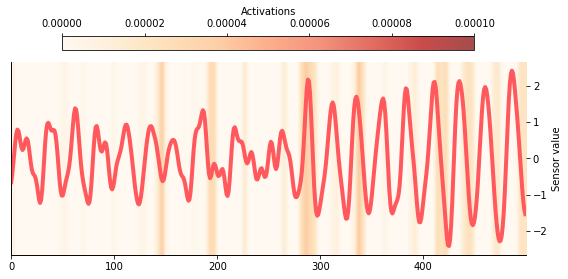

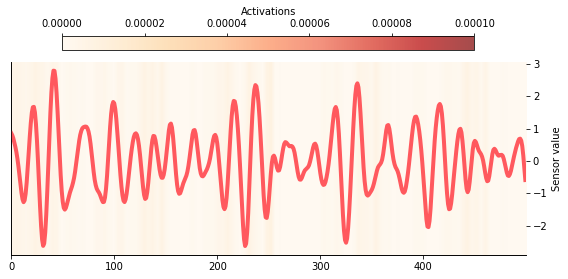

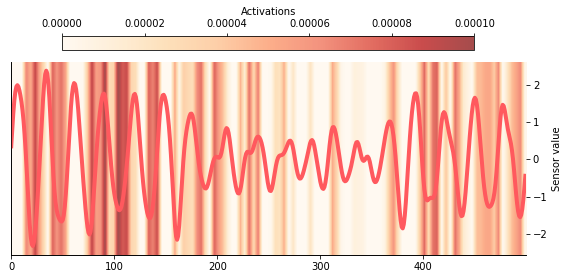

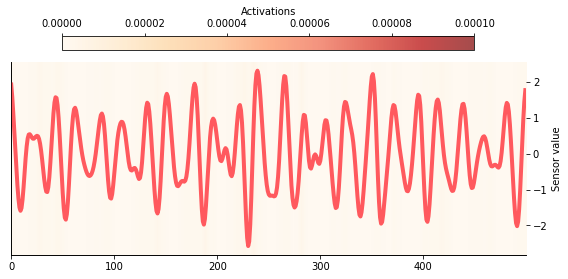

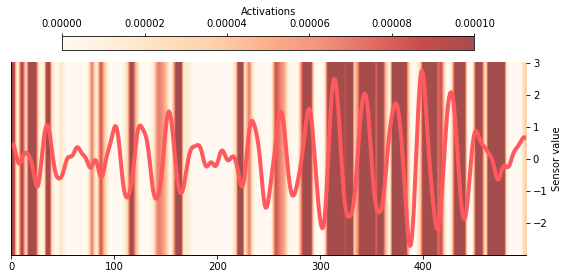

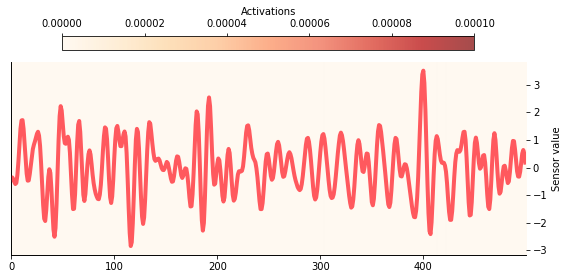

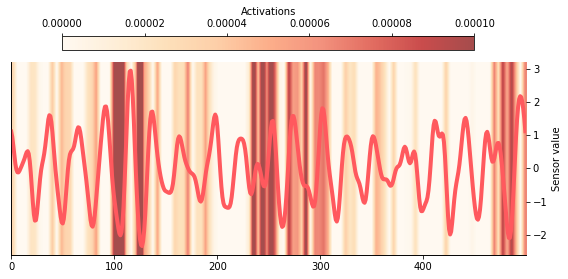

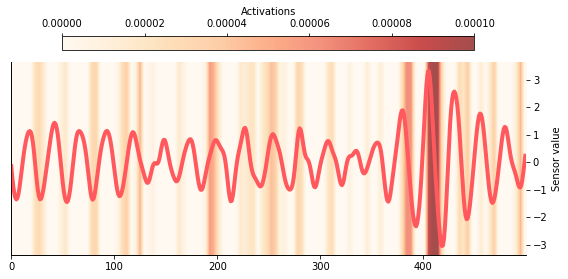

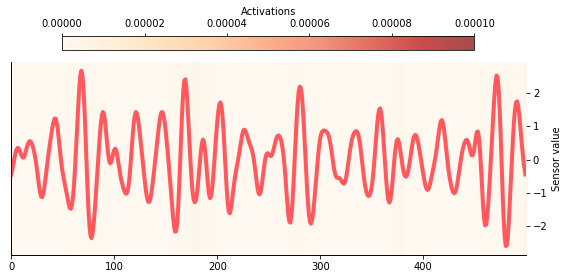

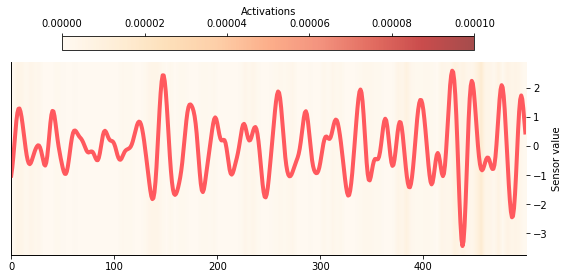

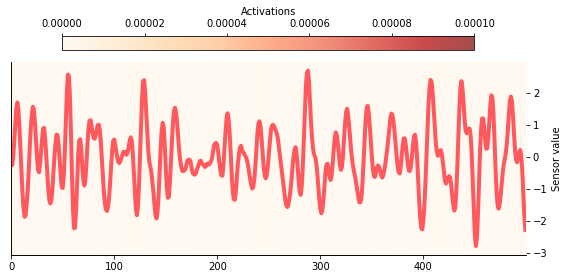

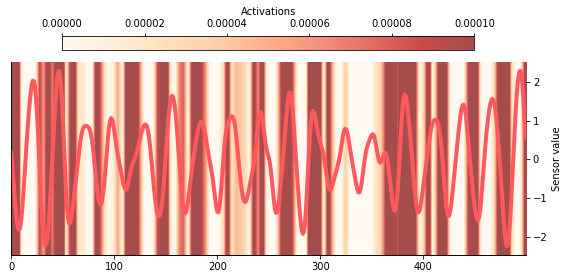

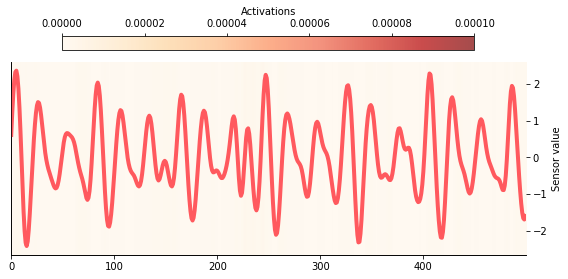

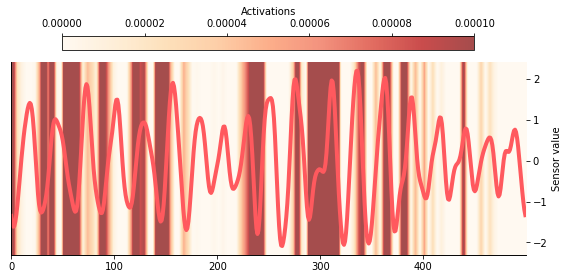

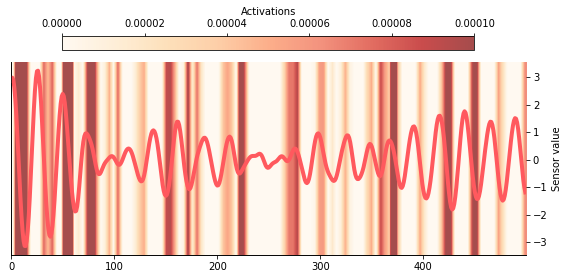

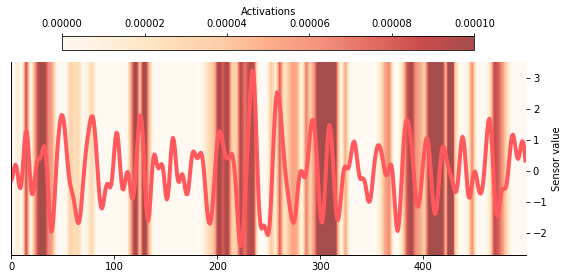

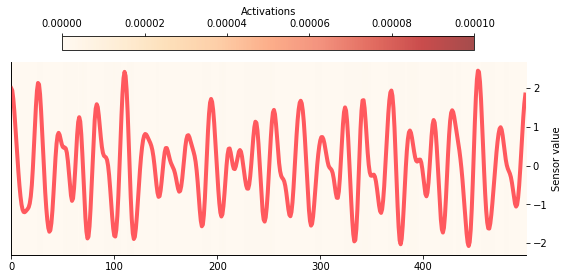

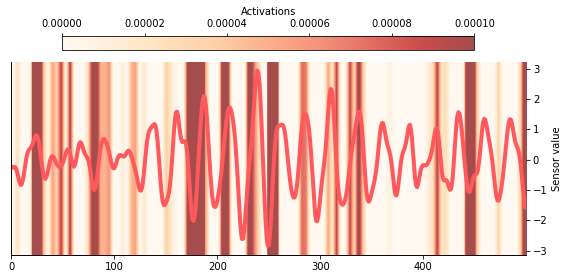

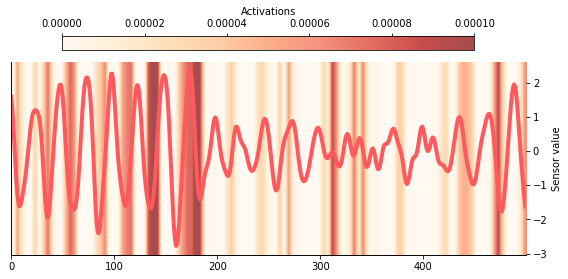

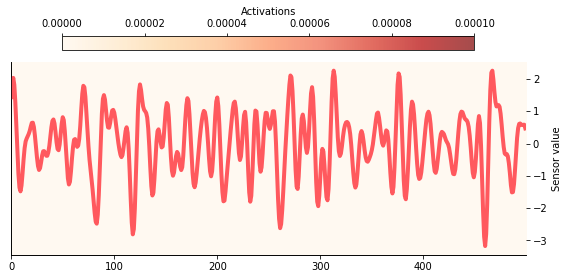

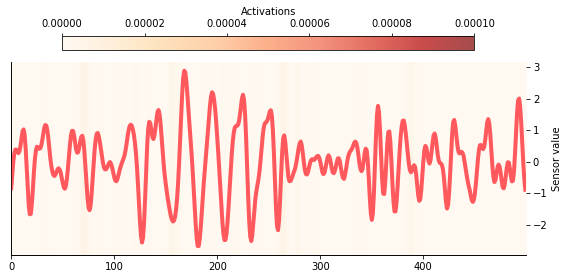

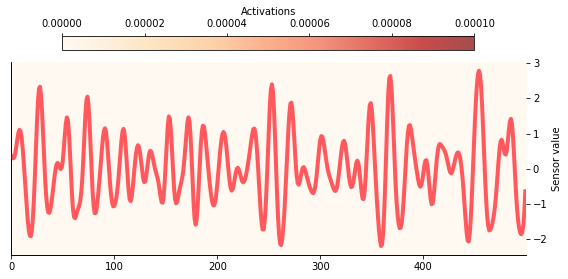

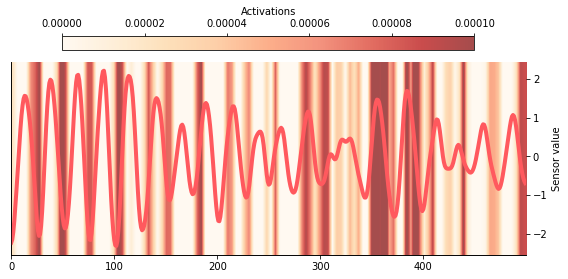

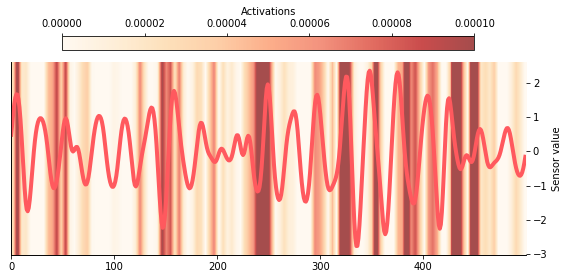

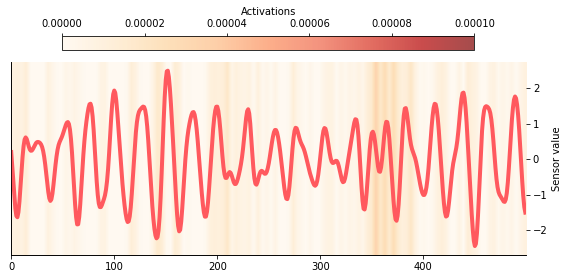

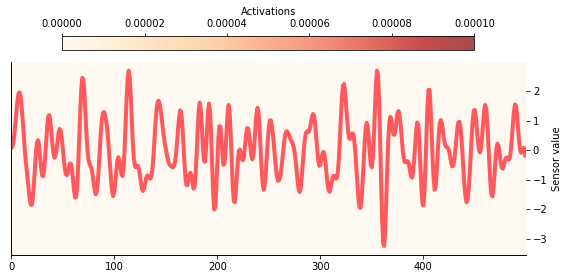

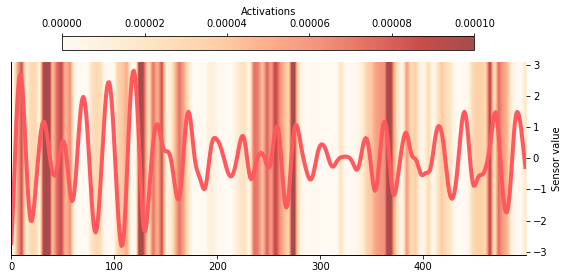

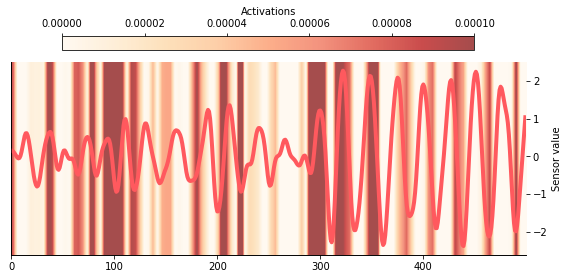

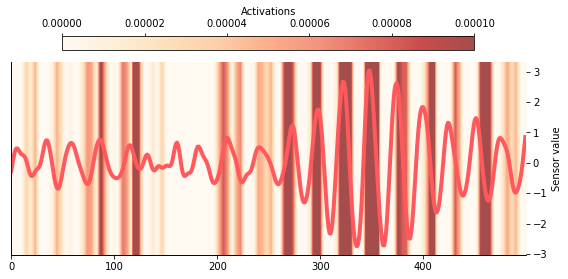

In [22]:
def reshape_transform(tensor, target_size):
    """ 
    Transforms a tensor to the required shape by interpolation
    Used to transform the tensor before last pooling layer to input size.
    Note: this should only interpolate time axis, not the feature axis!
    """
    if tensor.dim() == 1:
        tensor = tensor.reshape(1, -1)
    tensor = tensor.reshape((1, 1, tensor.shape[0], tensor.shape[1]))
    image_with_single_row = tensor[:, None, :, :]
    # Lets make the time series into an image with 16 rows for easier visualization on screen later
    return torch.nn.functional.interpolate(tensor, target_size, mode='bilinear')

def genereate_gradcam_explanation(model, x):
    pred = model.forward(x, cam=True)
    
    pred[0][0].backward()
    
    gradients = model.get_activations_gradient()    
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    # print("Pooled Gradients shape: {}".format(pooled_gradients.shape))
    
    activations = model.get_activations(x).detach()
    # print("Activations shape: {}".format(activations.shape))

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    mean_activations = torch.mean(activations, dim=1).squeeze()
    mean_activations = torch.maximum(mean_activations, torch.tensor(0))
    mean_activations = reshape_transform(mean_activations, (x.shape[-2], x.shape[-1]))
    return mean_activations


def plot_explanation_heatmap(x, y, explanation):
    """
    Function to plot explanation heatmap
    """        
    t = explanation.shape[-1] -1 # time 
    x = x.reshape(1, -1)
    explanation = explanation.reshape(1, -1)

    fig, ax =plt.subplots(figsize=(8, 4))
    colormap_activations = ax.imshow(explanation, aspect=200, vmin=0, vmax=1e-4, cmap="OrRd", alpha=0.7)
    plt.colorbar(colormap_activations, shrink=0.8, label="Activations", location="top", aspect=30)
    plt.yticks([])
    plt.twinx()
    plt.plot(x.squeeze(), linewidth=4)
    plt.ylabel("Sensor value")
    plt.xlabel("Time")
    fig.tight_layout()
    
    
# batch of data for explanations
x_batch, y_batch = next(iter(test_loader))


for i in range(x_batch.shape[0]):
    x = x_batch[i:i+1]
    y = y_batch[i:i+1]

    explanation = genereate_gradcam_explanation(model, x)
    plot_explanation_heatmap(x, 0, explanation)